In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms

from ilipy import ClipTypes, Session, OdometerTicks, OdometerTickRange, ViewDistance
from ilipy.database import DistanceCorrelation
from ilipy.features import Bookmarks
from ilipy.sensors import ArmAngleLookup
from ilipy import Clip, OdometerTicks, Session, fRange
from ilipy.channeldata import ChannelDataReader, ImageProfile
from ilipyutils.distances import get_frames_within_view_distance_interval
from ilipyutils.beamforming import Beamformer
from ilipyutils.configs import FF_DEFAULTS

from rnd.utils.modeling import get_model
from rnd.utils.transform import resize_to_224
from rnd.utils.dataset import NumpyImageFolder
from rnd.utils.data_utils import (
    set_ili_run,
    extract_arm_angles,
    create_arm_array,
)

In [3]:
run_number = 5
_, _, inspection_id, env, _, start_dist, end_dist = set_ili_run(run_number)

session = Session(environment="qa")
session.set_active_inspection(inspection_id)
dist_corr = DistanceCorrelation(session)

PySettings.cpp(46): ilipy: Build 0.17.1.10521 2088afaee0 release-ili-0.17 'Wed Jul  2 12:34:41 2025'
PySettings.cpp(47): Paths modulePath: F:/RandD/2025-Q2/.venv/Lib/site-packages/ilipy, userHomePath: C:/Users/aming1, identityPath: C:/Users/aming1/.aws/ilipy
Settings.cpp(246): Settings: loading settings from F:/RandD/2025-Q2/.venv/Lib/site-packages/ilipy/Data/Environments/defaults.json
Settings.cpp(246): Settings: loading settings from F:/RandD/2025-Q2/.venv/Lib/site-packages/ilipy/Data/Environments/qa.json
PyAuthenticator.cpp(239): Attempting an IAM role login as no username and password or environment variables were provided.
CognitoAuthenticator.cpp(168): Using IAM Credentials with roleArn: arn:aws:iam::010440185763:role/dv-backend
CognitoTokenVerifier.cpp(252): Successfully acquired STS credentials.
DatabaseWebSocket.cpp(168): WebSocket connection established to https://backend.ili-qa.darkvisiontech.com/dbservice/ws
DbHealthCheck.cpp(146): Database service health check complete: He

In [4]:
class PreprocessingModel(nn.Module):
    def __init__(self, model, transform):
        super().__init__()
        self.model = model
        self.transform = transform

    def forward(self, input_np_image):
        # Apply transform to NumPy image (expects single image, not batch)
        x = self.transform(input_np_image)
        x = x.unsqueeze(0)  # Add batch dimension
        return self.model(x)

In [5]:
def load_model(model_name, dense_units, dropout, model_path):
    """
    Load a PyTorch model with weights and return it along with the transform.

    Returns:
        model (torch.nn.Module): The loaded model ready for inference.
        transform (callable): The image preprocessing pipeline.
        weights: The weight metadata used for normalization.
    """
    model, weights = get_model(model_name, dense_units, dropout)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    transform = transforms.Compose([
        transforms.Lambda(resize_to_224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.expand(3, -1, -1)),
        transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
    ])

    wrapped_model = PreprocessingModel(model, transform)
    return wrapped_model

In [6]:
model = load_model("resnet", 128, 0.5, "rnd/models/new_models/resnet_final.pth")

(20, 500)


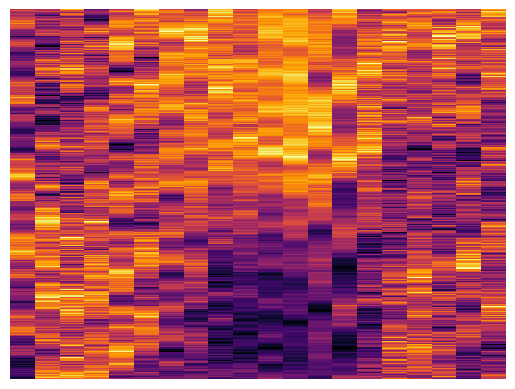

In [7]:
img_start = 100
length = 0.5
img_range = (img_start, img_start + length)
tick_sampling_interval = 10

arm_angles = extract_arm_angles(session, dist_corr, img_range, tick_sampling_interval=tick_sampling_interval)
num_tick_samples = int(length * 10000 / tick_sampling_interval)
img = create_arm_array(arm_angles, num_tick_samples=num_tick_samples, normalize=True)
# img = np.roll(img, shift=100)
print(img.shape)
plt.imshow(
    img.T, cmap="inferno", origin="lower", aspect="auto",
    interpolation="nearest",
)
plt.axis("off")
plt.show()

In [8]:
with torch.no_grad():
    probs = model(img).squeeze().cpu().numpy()
print(probs)

0.00014789727


In [ ]:
tick_sampling_interval = 10

# run_range = (7000, 7200)
run_range = (80, 100)
# run_range = (start_dist, end_dist)
img_length = 0.5
overlap = 0.0


start = run_range[0]
stop = run_range[1]
step = 0.5
num_steps = int((stop - start) / step)
points = np.linspace(start, stop, num_steps + 1)

results = []

for start_ in tqdm(points):
    end_ = round(start_ + img_length, 3)
    img_range = (start_, end_)
    
    arm_angles = extract_arm_angles(session, dist_corr, img_range, tick_sampling_interval=tick_sampling_interval)
    num_tick_samples = int(img_length * 10000 / tick_sampling_interval)
    img = create_arm_array(arm_angles, num_tick_samples=num_tick_samples, normalize=True)

    with torch.no_grad():
        prob = np.round(model(img).squeeze().cpu().numpy(), 3)

    results.append([round(start_, 3), end_, prob])


df = pd.DataFrame(results, columns=["start", "end", "prob"])
df.to_csv("full_run_fhr5.csv", index=False)

100%|██████████| 41/41 [00:30<00:00,  1.36it/s]


DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealthCheck.cpp(146): Database service health check complete: Healthy
CognitoTokenVerifier.cpp(252): Successfully acquired STS credentials.
PyAuthenticator.cpp(191): STS token refreshed successfully
DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealthCheck.cpp(146): Database service health check complete: Healthy
DbHealt